We start by importing the proper packages and functions. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser.devices import AnalogDevice, MockDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform, RampWaveform, BlackmanWaveform, CompositeWaveform
from pulser_simulation import QutipEmulator

# Intro to Pulser

Pulser is an ensemble of librairies for designing and simulating pulse sequences that are used to control neutral atom quantum computers (NAQCs), which are promising platforms for quantum computation and quantum simulation.

<center><img src="../images/pulser.png" width="1200"/></center>

In Pulser, a quantum information processing program is build very "physically". At the core lies the `Sequence` object, which is formed of:
- A `Device`, which can be virtual or a real device, with some given hardware constraints and a set of available laser channels. These channels can either be local (with a given target), which helps run digital algorithms, or they can be global, where the laser field acts on all neutral atoms.
- A `Pulse`, which is a set of time-varying waveforms for the laser's amplitude ($\Omega(t)$), detuning ($\delta(t)$) and phase ($\phi$, fixed for a given pulse). Each pulse has a given duration $T$.
- A `Register`, which is a dictionary of the atoms we have available in our system that will serve as qubits, and their coordinates. You can specify a new register by feeding in a list of coordinates.

Once a `Sequence` is formed, you can emulate it using the `QutipEmulator` function, which will return the final result of your quantum program running on this register of atoms. If you had access to a NAQC, you would send the `Sequence` object to be run on it!

In the following sections, you will play with the different features of Pulser.

# Section 1: Single qubit gates using laser pulses

In this section, we demonstrate the flexibility of Pulser to implement single qubit rotations. Our aim is to first use the `rydberg_global` channel, which uses the set of states $\{|g\rangle, |r\rangle\}$ to encode our two qubit states. Transitions between these levels can be addressed with a single laser, leading to:

<center><img src="../images/energy_levels_rydberg.png" width="500"/></center>

We act on this two-level system using a on-resonance pulse ($\delta = 0$), with a fixed phase, and control the area under the pulse $\theta = \int_0^\tau \Omega(t) dt$. For this, we will create a register `reg` with a single qubit, and initiate the `seq` object for the `Sequence`. We have to declare the channel we will use when we try to apply the pulse on the system; we use the `rydberg_global` channel which we name `ch0` for brevity. We can then generate a pulse with a fixed area `theta` and duration `duration` using the `BlackmanWaveform` function. After adding this pulse to our sequence `seq`, we draw it.

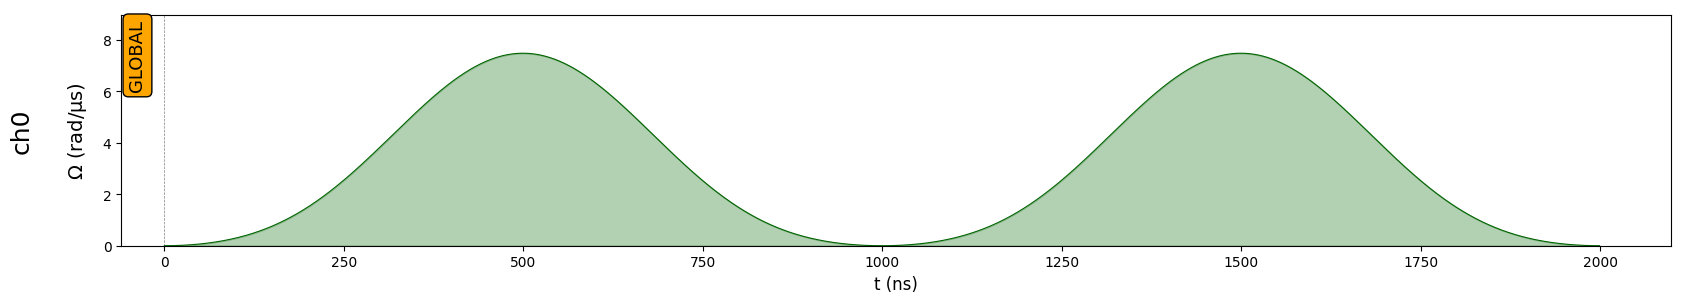

In [2]:
device_used = MockDevice #we define the virtual device we will use for this simple demonstration.
reg = Register({"q0": (0, 0)})
seq = Sequence(reg, device_used)
seq.declare_channel('ch0', 'rydberg_global')
# seq.declare_channel("ch0", "rydberg_local", initial_target="q0")

#we do one pulse
duration = 1000 #duration of the pulse
theta = np.pi #angle of rotation
phase = 0 # phase of pulse, defines the axis of rotation
waveform = BlackmanWaveform(duration, theta)  # Duration: 1us, Area: theta
pulse = Pulse.ConstantDetuning(waveform, detuning=0, phase = phase)
seq.add(pulse, "ch0")  # The first pulse
seq.add(pulse, "ch0")  # what if we add the pulse again?


seq.draw(draw_phase_curve=True)


We then simulate the sequence using the local emulator `QutipEmulator`. 

In [3]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run(progress_bar=True)

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
30.0%. Run time:   0.02s. Est. time left: 00:00:00:00
40.0%. Run time:   0.02s. Est. time left: 00:00:00:00
50.0%. Run time:   0.03s. Est. time left: 00:00:00:00
60.0%. Run time:   0.03s. Est. time left: 00:00:00:00
70.0%. Run time:   0.04s. Est. time left: 00:00:00:00
80.0%. Run time:   0.04s. Est. time left: 00:00:00:00
90.0%. Run time:   0.05s. Est. time left: 00:00:00:00
100.0%. Run time:   0.06s. Est. time left: 00:00:00:00
Total run time:   0.06s


Our final result is stored in `results`, which is a `qutip.QObj` object, and corresponds to the complex wavefunction obtained at the end of the quantum process. We then sample randomly this wavefunction by repeatedly collapsing it into the computational basis. This results in a `Counter` object which is just a big dictionary of bitstrings (where $|0\rangle \equiv |g\rangle$ and $|1\rangle \equiv |r\rangle$), where each has an associated count. We can plot the bitstring distribution.

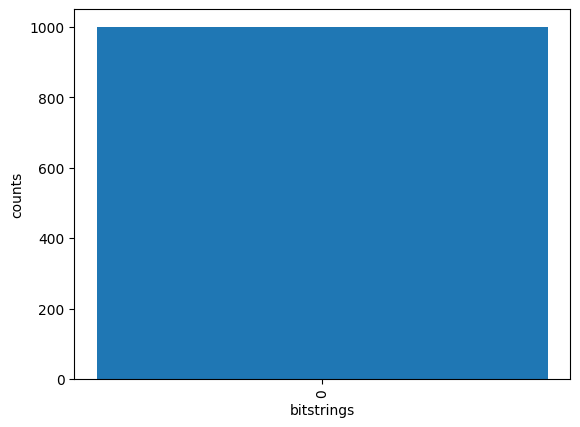

In [4]:
N_samples = 1000
count_dict = results.sample_final_state(N_samples=N_samples)
most_freq = {k: v for k, v in count_dict.items() if v > 0.05*N_samples} #filter the Counter dictionary so as not to show the infrequent bitstrings
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('counts')
plt.xlabel('bitstrings')
plt.show()

In this case, the result is trivial: with $100\%$ probability, we flipped the $|0\rangle$ state to the $|1\rangle$ excited state! I encourage you to test other angles $\theta$ and phase $\phi$ in order to see the result (for example, $\theta = \pi/2$). Notice that, since we collapse on the Rydberg basis, we cannot distinguish states such as $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$ and $\frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)$ - they would both appear with a $50%$ distribution of both $0,1$.

## Applying single qubit rotation on multiple qubits

We now create a register with two qubits separated by a given distance. We will then apply our pulses to this `Register`.

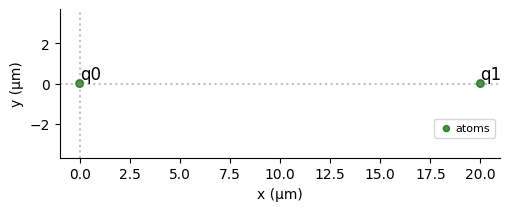

In [5]:
distance = 20 #we have to specify a distance between our qubits
reg = Register({"q0": (0, 0), "q1" : (distance,0)})
reg.draw()

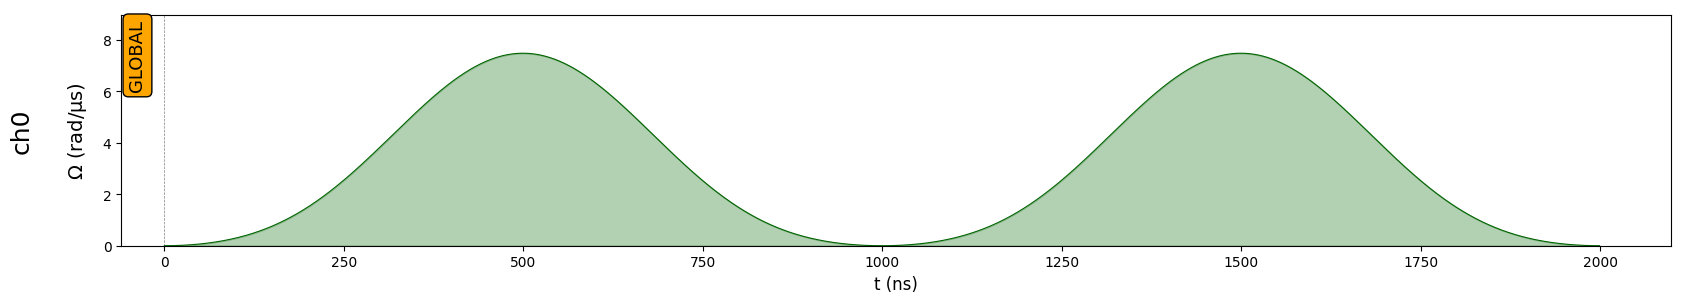

In [6]:
device_used = MockDevice #we define the virtual device we will use for this simple demonstration.
seq = Sequence(reg, device_used)
seq.declare_channel('ch0', 'rydberg_global')
# seq.declare_channel("ch0", "rydberg_local", initial_target="q0")

#we do one pulse
duration = 1000 #duration of the pulse
theta = np.pi #angle of rotation
phase = 0 # phase of pulse, defines the axis of rotation
waveform = BlackmanWaveform(duration, theta)  # Duration: 1us, Area: theta
pulse = Pulse.ConstantDetuning(waveform, detuning=0, phase = phase)
seq.add(pulse, "ch0")  # The first pulse
seq.add(pulse, "ch0")  # what if we add the pulse again?


seq.draw(draw_phase_curve=True)

Then, we emulate the sequence and plot the bitstring distribution.

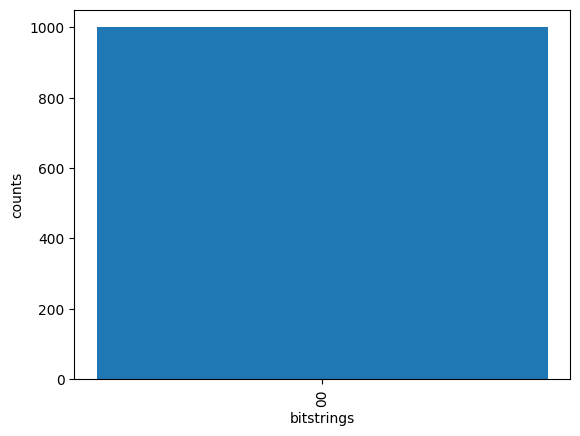

In [7]:
simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=1, #change the sampling of the wavefunction
                                    with_modulation=False, #modulate the signal like a real device
                                    )
results = simul.run(progress_bar=False)
N_samples = 1000
count_dict = results.sample_final_state(N_samples=N_samples)
most_freq = {k: v for k, v in count_dict.items() if v > 0.05*N_samples}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('counts')
plt.xlabel('bitstrings')
plt.show()

Note that, changing the distance between the atoms `q0` and `q1` will result in some strange results at short distances...

## Other pulses

We can use different types of pulses, all with the same area under them, to see if the result changes.

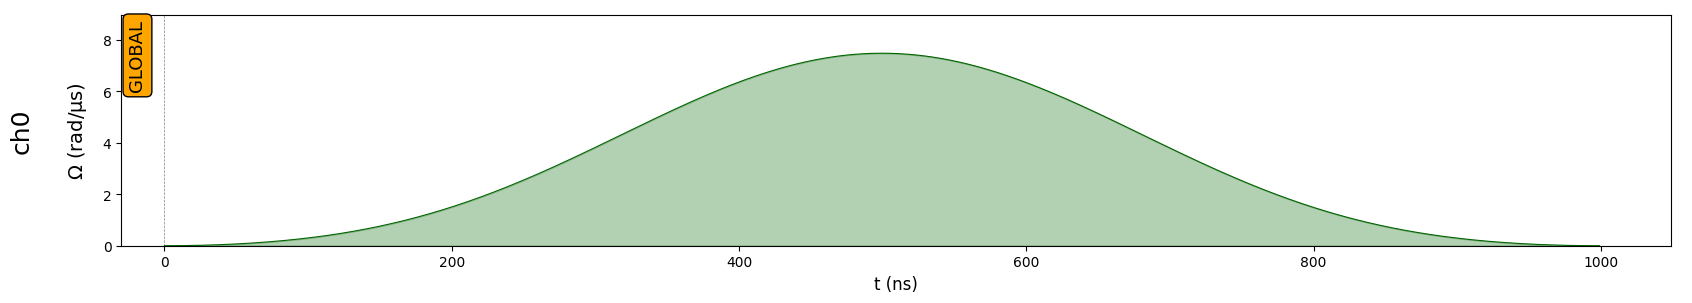

In [8]:
device_used = MockDevice #we define the virtual device we will use for this simple demonstration.
seq = Sequence(reg, device_used)
seq.declare_channel('ch0', 'rydberg_global')

theta = np.pi #angle of rotation
phase = 0 # phase of pulse, defines the axis of rotation

#create different waveforms of area theta
#Blackman waveform (fixed area, gaussian pulse)
waveform = BlackmanWaveform(1000, theta)  
#Constant waveform
# waveform = ConstantWaveform(duration = 1000, value = theta)
#Ramp waveform
# waveform = RampWaveform(duration = 2000, start = 0, stop = theta)
#Composite: Ramp + constant
# waveform_1 = RampWaveform(duration = 2000, start = 0, stop = theta/2)
# waveform_2 = ConstantWaveform(duration = 1000, value = theta/2)
# waveform = CompositeWaveform(waveform_1, waveform_2)

pulse = Pulse.ConstantDetuning(waveform, detuning=0, phase = phase)
seq.add(pulse, "ch0")  # The first pulse
# seq.add(pulse, "ch0")  # what if we add the pulse again?


seq.draw(draw_phase_curve=True)

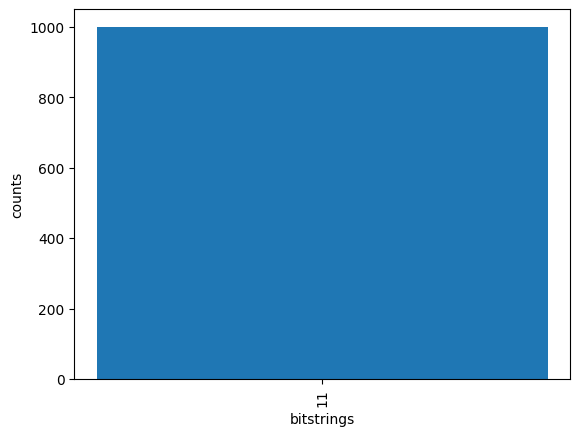

In [9]:
simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=1, #change the sampling of the wavefunction
                                    with_modulation=False, #modulate the signal like a real device
                                    )
results = simul.run(progress_bar=False)
N_samples = 1000
count_dict = results.sample_final_state(N_samples=N_samples)
most_freq = {k: v for k, v in count_dict.items() if v > 0.05*N_samples}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('counts')
plt.xlabel('bitstrings')
plt.show()

## The phase shift

We have that an arbitrary 2x2 unitary can be written through a decomposition in terms of rotations around the $x$ and $z$ axis:

$$ U(\gamma, \theta, \phi) = R_z(\gamma) R_x(\theta) R_z (\phi)$$

We also have, from the presentation, that a resonant pulse (detuning $\delta = 0$) leads to a general rotation of the form

$$R_{\vec{n}(\phi)} (\theta) = \exp (-i \frac{\theta}{2} \vec{n} \cdot \vec{\sigma}) = R_x(-\phi) R_x(\theta) R_z(\phi)$$

where $\vec{n} = (\cos \phi, -\sin \phi, 0)$. Thus, an arbitrary 2x2 unitary is given by

$$U(\gamma, \theta, \phi) = R_z(\gamma + \phi) R_{\vec{n}(\phi)} (\theta)$$

This $R_z(\kappa)$ can be done by performing a *virtual phase shift*, meaning that any subsequently applied pulse will their phase shifted! Let's see how it works.

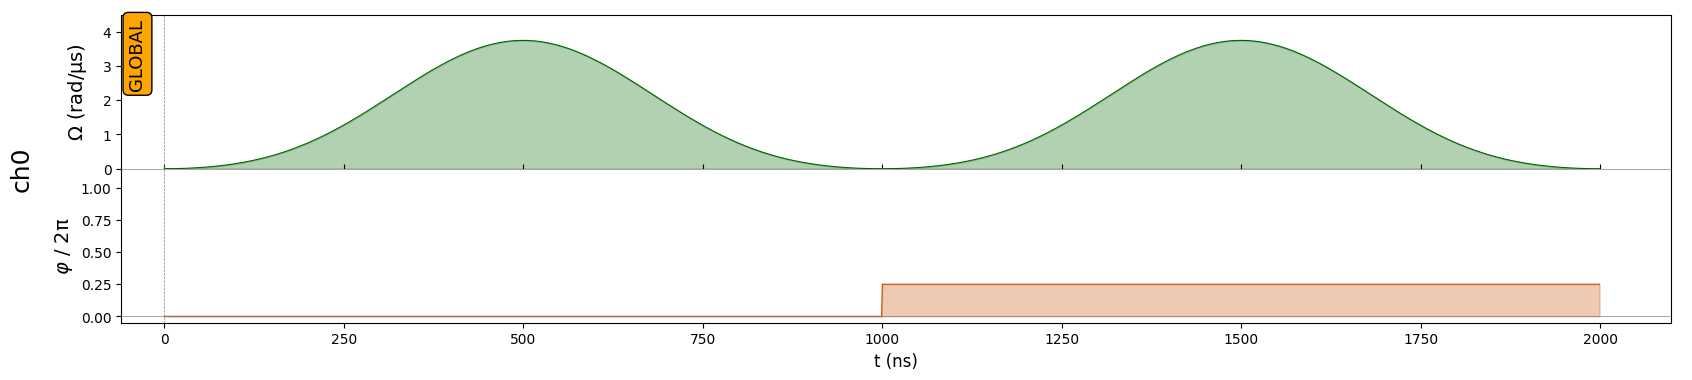

In [10]:
device_used = MockDevice #we define the virtual device we will use for this simple demonstration.
seq = Sequence(reg, device_used)
seq.declare_channel('ch0', 'rydberg_global')

#we do one pulse
duration = 1000 #duration of the pulse
theta = np.pi/2 #angle of rotation
phase = 0 # phase of pulse, defines the axis of rotation
waveform = BlackmanWaveform(duration, theta)  # Duration: 1us, Area: theta
pulse_1 = Pulse.ConstantDetuning(waveform, detuning=0, phase = 0, post_phase_shift=np.pi/2)
pulse_2 = Pulse.ConstantDetuning(waveform, detuning=0, phase = 0)
seq.add(pulse_1, "ch0")  # The first pulse
seq.add(pulse_2, "ch0")  # what if we add the pulse again?


seq.draw(draw_phase_curve=True)

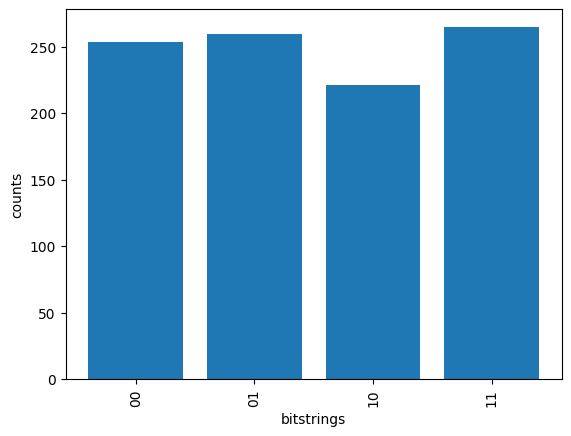

In [11]:
simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=1, #change the sampling of the wavefunction
                                    with_modulation=False, #modulate the signal like a real device
                                    )
results = simul.run(progress_bar=False)
N_samples = 1000
count_dict = results.sample_final_state(N_samples=N_samples)
most_freq = {k: v for k, v in count_dict.items() if v > 0.05*N_samples}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('counts')
plt.xlabel('bitstrings')
plt.show()

## Exercice 1.1: Décomposition de certaines rotations

<center><img src="../images/Quantum_Logic_Gates_2.png" width="500"/></center>


- Comment écrit-on une porte de Hadamard pour préparer l'état $\frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)$ à partir de $|0\rangle$?
- Comment vérifier que l'on a réellement créé cet état, et non pas $\frac{1}{\sqrt{2}} (|0\rangle + e^{i\beta}|1\rangle)$? (indice: $U^{\dagger} U = 1$, mais $U^{\dagger} \tilde{U} \neq 1$...)

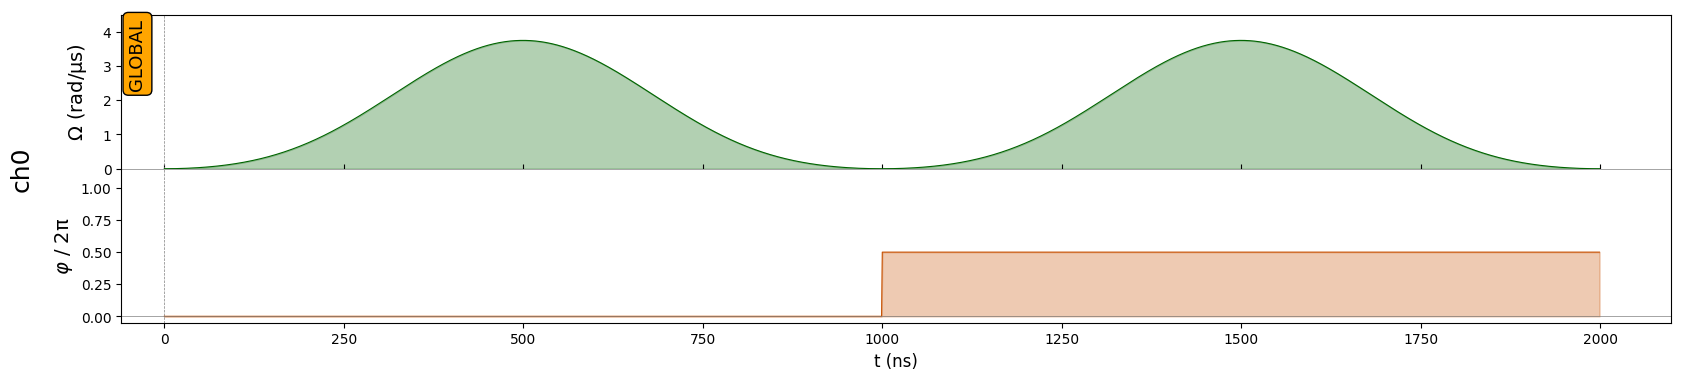

In [20]:
device_used = MockDevice #we define the virtual device we will use for this simple demonstration.
reg = Register({"q0": (0, 0)})
seq = Sequence(reg, device_used)
seq.declare_channel('ch0', 'rydberg_global')
# seq.declare_channel("ch0", "rydberg_local", initial_target="q0")

#we do one pulse
duration = 1000 #duration of the pulse
theta = np.pi/2 #angle of rotation
post_phase_shift = np.pi
phase = 0 # phase of pulse, defines the axis of rotation
waveform = BlackmanWaveform(duration, theta)  # Duration: 1us, Area: theta
pulse = Pulse.ConstantDetuning(waveform, detuning=0, phase = phase, post_phase_shift=post_phase_shift)
seq.add(pulse, "ch0")  # The first pulse
seq.add(pulse, "ch0")


seq.draw(draw_phase_curve=True)


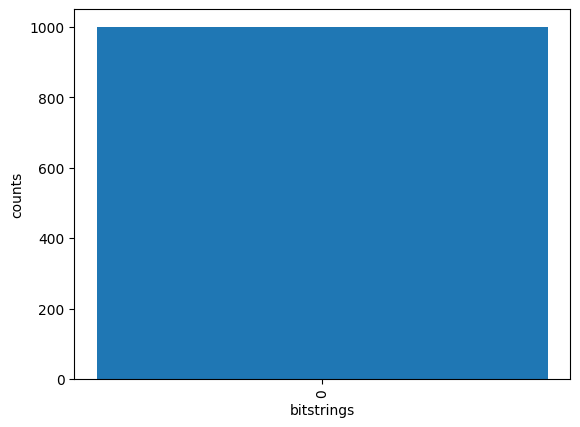

In [21]:
simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=1, #change the sampling of the wavefunction
                                    with_modulation=False, #modulate the signal like a real device
                                    )
results = simul.run(progress_bar=False)
N_samples = 1000
count_dict = results.sample_final_state(N_samples=N_samples)
most_freq = {k: v for k, v in count_dict.items() if v > 0.05*N_samples}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('counts')
plt.xlabel('bitstrings')
plt.show()

## Exercice 1.2: 

- Pouvez-vous prédire ce que sera le résultat d'appliquer votre porte de Hadamard à deux qubits indépendemment? Quel sera la distribution des bitstrings?
- Qu'est-ce qui arrive lorsque vous tentez de faire votre porte de Hadamard *globalement* sur 2 qubits séparés par $r_{12} = 20 \mu m$?
- Qu'est-ce qui arrive lorsque vous tentez de faire votre porte de Hadamard *globalement* sur 2 qubits séparés par $r_{12} = 4 \mu m$?
- À quelle distance avez-vous besoin de placer les atomes pour obtenir le résultat attendu?
- Pouvez-vous créer un graphe comparant l'état réalisé à $r_{12} = r$ v.s. ce à quoi vous vous attendez?

# Section 3: The Rydberg blockade effect

We saw in the previous exercise that if we try to send arbitrary pulses on atoms in the `rydberg` basis, we get confusing answers. 

This is because atoms in the excited Rydberg state have a *repulsive* interaction between themselves! For two atoms $1,2$, the interaction Hamiltonian is given by $H_{Ryd}/\hbar = \frac{C_6}{r_{12}^6} n_1 n_2$ where $n_i = |r_i\rangle \langle r_i|$. This interaction decreases very fast ($1/r^6$ with $r$ the distance between two atoms), but for short distances, it acts to shift the local energy levels and *prohibits* double occupancy of the Rydberg excited state.

<center><img src="../images/blockade.png" width="500"/></center>

This is a dynamic effect: it also depends on the intensity of the on-resonance laser field $\Omega$ we shine on the atoms. In this regard, a finite $\Omega$ will generate a certain blockade radius $R_b = (C_6/\Omega)^{1/6}$, such that, if $R_{interatomic} > R_b$, we can generate any state we want. However, if $R_{interatomic} < R_b$, the state $|rr>$ is energetically forbidden (blockaded) and one gets an entangled state.

In this experiment, we send a global on-resonance pulse with $\theta = \pi$, $\phi = 0$, which is like a $R_x(\pi)$ done in parallel on both atoms (global pulse). This will attempt to put all qubits in the $|1\rangle = |r\rangle$ state. This is done through the `run_RX_on_atom_pair` function. We then change the distance between atoms, and plot the distribution on the obtained bitstrings.

In [22]:
def run_RX_on_atom_pair(R_interatomic, param = (0, np.pi)):
    """
    input:
    R_interatomic : distance between atoms 
    param: tuple of (phi, theta) for the on-resonance pulse
    output:
    sequence, results
    """
    q_dict = {
        "q0": np.array([-R_interatomic/2, 0.0]),
        "q1": np.array([R_interatomic/2, 0.0]),
    }
    reg = Register(q_dict)

    seq = Sequence(reg, device_used)
    seq.declare_channel("ryd", "rydberg_global")
    duration = 300 #duration of the pulse
    phase, theta = param
    amp_wf = BlackmanWaveform(duration, theta)  # Duration: 1us, Area: theta
    detuning_wf = ConstantWaveform(duration, 0.0)

    pulse = Pulse(amp_wf, detuning_wf, phase=phase)
    seq.add(pulse, "ryd")  # The first pulse

    simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=1, #change the sampling of the wavefunction
                                    with_modulation=False, #modulate the signal like a real device
                                    )
    results = simul.run(progress_bar=False)
    return seq, results



We can plot the generated sequence for a given `R_interatomic` and `param`, as well as the bitstring counts.

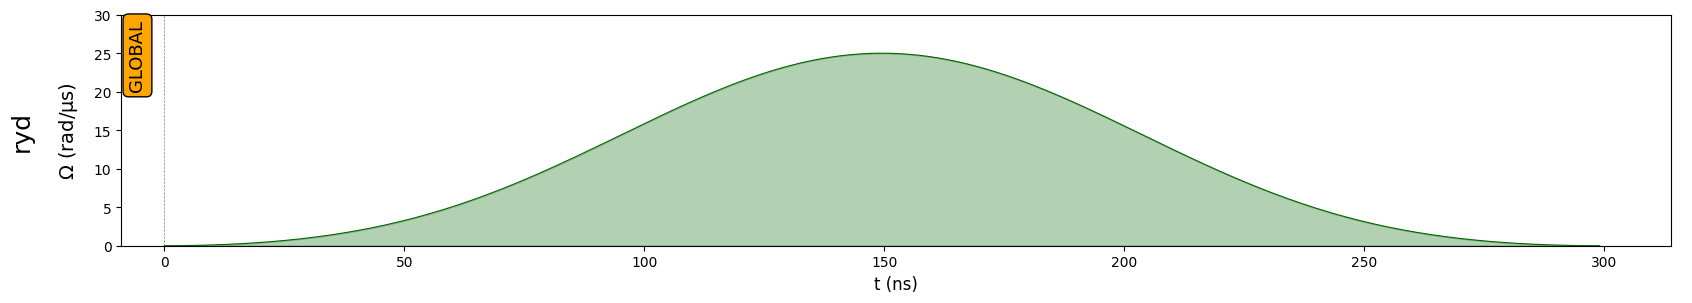

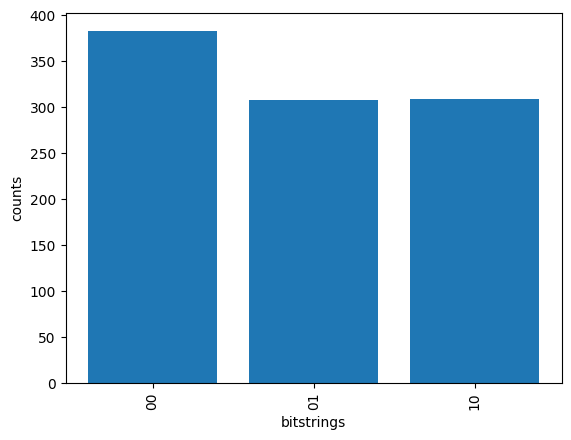

In [23]:
seq, results = run_RX_on_atom_pair(R_interatomic = 6, param = (0, np.pi))
seq.draw()
count_dict = results.sample_final_state(N_samples=1000)
most_freq = {k: v for k, v in count_dict.items() if v > 0.05*N_samples}
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('counts')
plt.xlabel('bitstrings')
plt.show()


We compute the function for 12 distances between $5 \mu m$ and $12 \mu m$. We store the count of each of the possible bitstrings (see the `strings`).

In [24]:
distances = np.linspace(5, 14, 12)
data = np.zeros((4, len(distances)))
strings = ['00', '01', '10', '11']
for n in range(len(distances)):
    dist = distances[n]
    _, results = run_RX_on_atom_pair(R_interatomic = dist, param = (0, np.pi))
    count_dict = results.sample_final_state(N_samples=1000)
    res_dict = {k: v for k, v in count_dict.items() if v > 0.05*N_samples}
    for i in range(4):
        data[i, n] = res_dict.get(strings[i], 0)/1000
        

We plot the expectation value of each of the four bitstrings as a function of the interatomic distance.

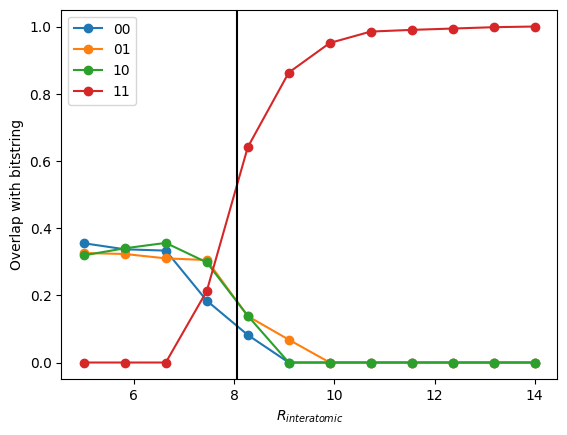

In [25]:
for i in range(4):
    plt.plot(distances, data[i,:], 'o-', label = strings[i])
plt.xlabel(r'$R_{interatomic}$')
plt.ylabel('Overlap with bitstring')
plt.axvline(x = AnalogDevice.rydberg_blockade_radius(np.pi), color = 'black') #this calculates the Rydberg blockade radius
plt.legend()

Here, the blockade radius is dictated by the $\Omega_{eff} = \theta/t = \pi \; \text{rad}/\mu s$ of the fixed duration, fixed area pulse. This sets $R_b \sim 8 \mu m$. You can see that, for $R < R_b$, the $|11\rangle$ is unoccupied, and we create a superposition $\psi_{mix} = \alpha |00\rangle + \beta |01\rangle + \gamma |10\rangle$, with $|\alpha| = |\beta| = |\gamma|$. For $R > R_b$, the $|11\rangle$ is the only occupied state - our $R_X(\pi)$ has produced the desired effect.

## Exercice 2.1: Une vraie paire de Bell. 

- Comment modifierez vous le résultat plus haut pour faire en sorte que l'état $|00\rangle$ (en bleu ci-haut) ne soit pas présent à courte distance? (indice: vous devez promouvoir les états excités - à quoi cela correspond-t'il dans les paramètres laser?)

## Exercice 2.2: L'état W

- Pouvez-vous adapter ce que vous avez appris ici pour générer des états $|W\rangle$, i.e. des états à $N$ qubits qui sont hautement intriqués?

Un état W est la généralisation d'une paire de Bell pour $N$ qubits. Cet état intriqué est donné par

$|W\rangle = \frac{1}{\sqrt{n}} ( |100\cdots 0\rangle + |010\cdots 0\rangle + \cdots + |00\cdots 01\rangle$

Comme on peux le voir, si l'un des qubits est perdu (mesuré ou affecté par le bruit), le reste du système reste intriqué. Cet aspect robust est une différence clé comparé à l'état GHZ.
